In [1]:
# Refer to path of package
import sys
sys.path.append('/Users/watcharapongwongrattanasirikul/Documents/Git/Jupyter/my_env/lib/python3.8/site-packages')

In [2]:
# Import Lib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
import re
from random import choices, randint, randrange, uniform

In [3]:
from ml_helper import MlHelper
from eda_helper import EdaHelper
from sampling_helper import SamplingHelper
from impute_helper import ImputeHelper
from impute_helper import imputation_strategy
from ml_helper import model_type
from ml_helper import resampler_type
from ml_helper import scaler_type

In [4]:
file_path = '/Users/watcharapongwongrattanasirikul/Documents/Git/predictive-maintenance/main.csv'

df = pd.read_csv(file_path)
df.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [5]:
# Rename of columns
df = df.rename(columns={
    'Air temperature [K]':'AirTemp',
    'Process temperature [K]':'ProcessTemp',
    'Rotational speed [rpm]':'RotationalSpeed',
    'Torque [Nm]':'Torque',
    'Tool wear [min]': 'ToolWear',
    'Machine failure':'MF'
})
df.head()

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [6]:
def plot_class_distribution(df, label):
    c = ['lightsteelblue', 'Red']
    df.groupby('MF').size().plot(kind="bar", color=c)
    plt.title('Class Distribution', fontsize=18)
    plt.yticks(np.arange(0, 14000, 2000))
    # plt.grid()

    for index, value in enumerate(df.groupby(label).size()):
        c_label = ''
        if index == 0:
            c_label = 'Black'
        else:
            c_label = 'Black'
        plt.text(index - 0.1, value + 1000, str(value), color=c_label, fontsize=14)
    plt.xticks(rotation = 0) 
    sns.despine()
    
    plt.savefig('class_distribution.png')

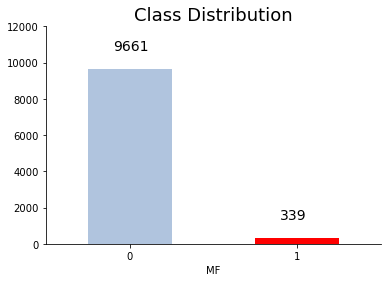

In [7]:
plot_class_distribution(df, 'MF')

In [8]:
df.head(2)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0


In [9]:
# The importance feature of power failure  is Power then we create the Power feature 
# Power(kW) = Torque (N.m) x Speed (rpm)

df['Power'] = df['Torque'] * df['RotationalSpeed']
df.head(2)

,UDI,Product ID,Type,AirTemp,ProcessTemp,RotationalSpeed,Torque,ToolWear,MF,TWF,HDF,PWF,OSF,RNF,Power
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,66382.8
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,65190.4


In [12]:
def plot_feature_class(df, feautures, label, window_size=10, name=None):
    fig, ax = plt.subplots(len(feautures)+1, 1, figsize=(42,15))
    sns.lineplot(ax=ax[1], x=range(df.shape[0]), y=label, data=df, alpha=0.5, color='red' )
    
    
    for idx, feature in enumerate(feautures):
        sns.lineplot(ax=ax[0], x=range(df.shape[0]), y=feautures[idx], data=df, alpha=0.5, color='blue' )
#         #sns.lineplot(ax=ax[idx+1], x=range(window_size-1, df.shape[0]), y=get_moving_average(df[feature], window_size), alpha=0.5 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() for i in range(df.shape[0])], alpha=0.2 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() + df[feature].std() for i in range(df.shape[0])], alpha=0.2 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() - df[feature].std() for i in range(df.shape[0])], alpha=0.2 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() + (2 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() - (2 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() + (3 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )
#         sns.lineplot(ax=ax[idx+1], x=range(0, df.shape[0]), y=[df[feature].mean() - (3 * df[feature].std()) for i in range(df.shape[0])], alpha=0.2 )

    if name is not None:
        plt.savefig(f'{name}.png')

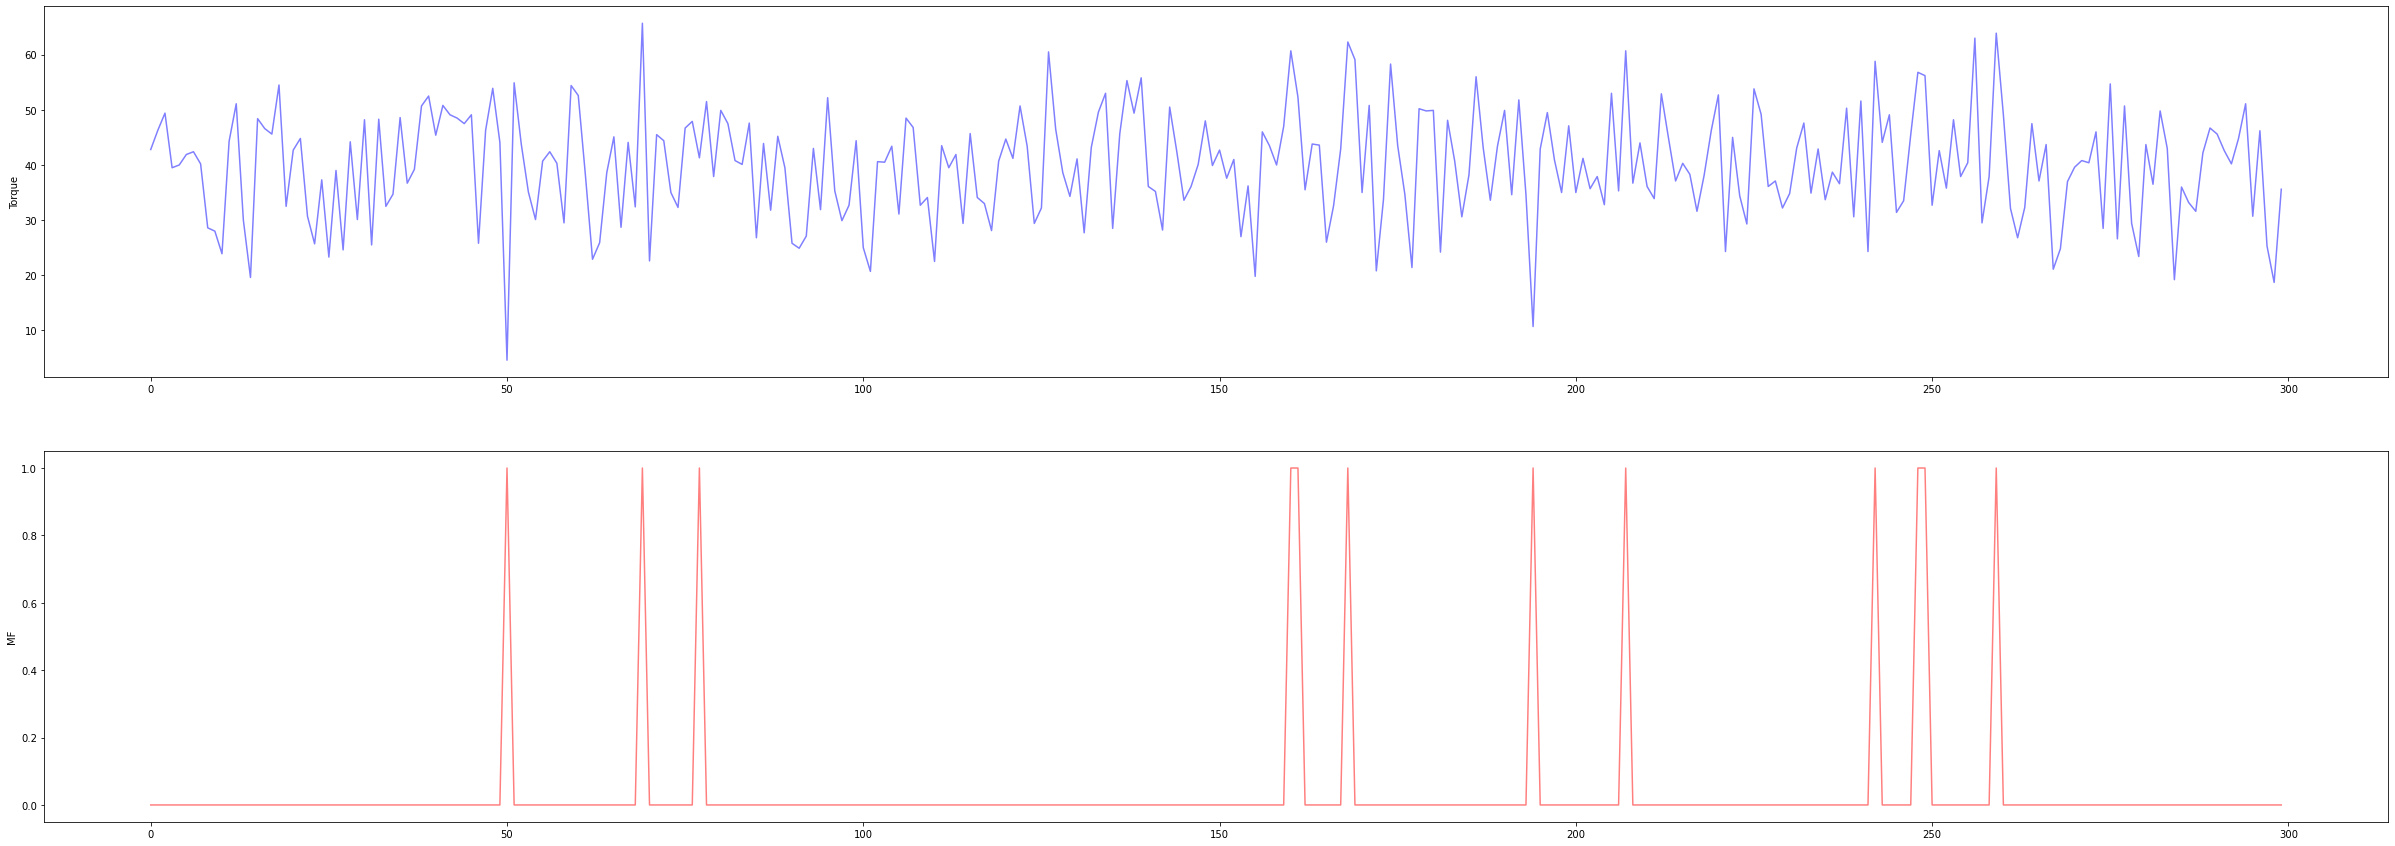

In [13]:
df_plot = df[0:300]
plot_feature_class(df_plot, ['Torque'],'MF', 'pwf_plot')